In [15]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import resnet50
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow import convert_to_tensor
import tensorflow.keras.backend as K
from matplotlib import pyplot as plt
from sklearn.utils import shuffle
import keras
import pandas as pd
import numpy as np
import pathlib
import time
import cv2
import os
import random
import re
tf.compat.v1.enable_eager_execution()

In [16]:
images_path = "../../Dataset/img_celeba_cropped/"
attrs = "../../Dataset/celeb_attrs_processed.txt"
celeb = "../../Dataset/celeb_identity_processed.txt"

In [17]:
attrs_df = pd.read_csv(attrs)
celeb_df = pd.read_csv(celeb)
celeb_df.identity = celeb_df.identity.astype(str)
celeb_df

,image,identity
0,000001.jpg,2880
1,000002.jpg,2937
2,000004.jpg,5805
3,000005.jpg,9295
4,000006.jpg,4153
...,...,...
137917,202593.jpg,10139
137918,202594.jpg,8984
137919,202595.jpg,9761
137920,202597.jpg,9852


In [4]:
attrs_df

,image,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,Brown_Hair,...,Mouth_Slightly_Open,No_Beard,Oval_Face,Pointy_Nose,Smiling,Wavy_Hair,Wearing_Earrings,Wearing_Lipstick,Wearing_Necklace,Young
0,000001.jpg,1,1,-1,-1,-1,-1,-1,-1,1,...,1,1,-1,1,1,-1,1,1,-1,1
1,000002.jpg,-1,-1,1,-1,-1,1,-1,-1,1,...,1,1,-1,-1,1,-1,-1,-1,-1,1
2,000004.jpg,-1,1,-1,-1,-1,-1,-1,-1,-1,...,-1,1,-1,1,-1,-1,1,1,1,1
3,000005.jpg,1,1,-1,-1,1,-1,-1,-1,-1,...,-1,1,-1,1,-1,-1,-1,1,-1,1
4,000006.jpg,1,1,-1,-1,1,-1,-1,-1,1,...,1,1,-1,-1,-1,1,1,1,-1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137917,202593.jpg,-1,1,-1,1,-1,-1,-1,-1,-1,...,1,1,1,1,1,-1,-1,1,-1,1
137918,202594.jpg,1,1,-1,-1,1,-1,-1,-1,-1,...,-1,1,-1,1,-1,1,1,1,-1,1
137919,202595.jpg,-1,1,-1,-1,1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,1,-1,1
137920,202597.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,1,1,-1,-1,1,-1,-1,-1,-1,1


In [5]:
image_shape=(224, 224, 3)

batch_size=16
lr=0.00001

In [6]:
def get_positive_pair(image, celeb_df=celeb_df):
    identity = celeb_df.loc[celeb_df["image"] == image]["identity"].to_string(index=False)
    celeb_df.drop(np.where(celeb_df["image"] == image)[0], inplace=True)
    celeb_df.reset_index(inplace=True, drop=True)
    
    image_pair = celeb_df.loc[celeb_df["identity"] == identity]["image"].sample(1).to_string(index=False)
    attrs_df.drop(np.where(attrs_df["image"] == image_pair)[0], inplace=True)
    attrs_df.reset_index(inplace=True, drop=True)
    celeb_df.drop(np.where(celeb_df["image"] == image_pair)[0], inplace=True)
    celeb_df.reset_index(inplace=True, drop=True)
    
    return image_pair, identity

In [7]:
def get_negative_pair(identity, celeb_df=celeb_df):
    negative_pair = celeb_df.loc[celeb_df["identity"] != identity]["image"].sample(1).to_string(index=False)
    return negative_pair

In [8]:
def get_balanced_pairs(no_pairs, attrs_df=attrs_df):
    anchors = []
    pairs = []
    labels = []
    attrs_in_df = attrs_df.columns
    
    for pair_no in range(no_pairs):
        for attr in attrs_in_df[1:]:
            anchor = attrs_df.loc[attrs_df[attr] == 1]["image"].sample(1).to_string(index=False)
            anchors.append(anchor)
            
            attrs_df.drop(np.where(attrs_df["image"] == anchor)[0], inplace=True)
            attrs_df.reset_index(inplace=True, drop=True)
            positive_pair, identity = get_positive_pair(anchor)
            pairs.append(positive_pair)
            labels.append(1)
            
            negative_pair = get_negative_pair(identity)
            anchors.append(positive_pair)
            pairs.append(negative_pair)
            labels.append(0)
            
    bp_df = pd.DataFrame(list(zip(anchors, pairs, labels)), columns=["left", "right", "label"])
    
            
    return bp_df

In [9]:
balanced_df = get_balanced_pairs(100)

In [10]:
balanced_df["left"] = images_path + balanced_df["left"]
balanced_df["right"] = images_path + balanced_df["right"]
balanced_df

,left,right,label
0,../../Dataset/img_celeba_cropped/121281.jpg,../../Dataset/img_celeba_cropped/123847.jpg,1
1,../../Dataset/img_celeba_cropped/123847.jpg,../../Dataset/img_celeba_cropped/047936.jpg,0
2,../../Dataset/img_celeba_cropped/178183.jpg,../../Dataset/img_celeba_cropped/172169.jpg,1
3,../../Dataset/img_celeba_cropped/172169.jpg,../../Dataset/img_celeba_cropped/124221.jpg,0
4,../../Dataset/img_celeba_cropped/172288.jpg,../../Dataset/img_celeba_cropped/171953.jpg,1
...,...,...,...
4395,../../Dataset/img_celeba_cropped/131822.jpg,../../Dataset/img_celeba_cropped/103040.jpg,0
4396,../../Dataset/img_celeba_cropped/121579.jpg,../../Dataset/img_celeba_cropped/078121.jpg,1
4397,../../Dataset/img_celeba_cropped/078121.jpg,../../Dataset/img_celeba_cropped/126965.jpg,0
4398,../../Dataset/img_celeba_cropped/022924.jpg,../../Dataset/img_celeba_cropped/116694.jpg,1


In [11]:
balanced_df = shuffle(balanced_df)
balanced_df.reset_index(inplace=True, drop=True)
balanced_df

,left,right,label
0,../../Dataset/img_celeba_cropped/018560.jpg,../../Dataset/img_celeba_cropped/062414.jpg,0
1,../../Dataset/img_celeba_cropped/187173.jpg,../../Dataset/img_celeba_cropped/196734.jpg,1
2,../../Dataset/img_celeba_cropped/017065.jpg,../../Dataset/img_celeba_cropped/140481.jpg,0
3,../../Dataset/img_celeba_cropped/150046.jpg,../../Dataset/img_celeba_cropped/196991.jpg,0
4,../../Dataset/img_celeba_cropped/021903.jpg,../../Dataset/img_celeba_cropped/009305.jpg,1
...,...,...,...
4395,../../Dataset/img_celeba_cropped/055389.jpg,../../Dataset/img_celeba_cropped/160152.jpg,1
4396,../../Dataset/img_celeba_cropped/074423.jpg,../../Dataset/img_celeba_cropped/171642.jpg,0
4397,../../Dataset/img_celeba_cropped/134024.jpg,../../Dataset/img_celeba_cropped/151990.jpg,1
4398,../../Dataset/img_celeba_cropped/151997.jpg,../../Dataset/img_celeba_cropped/130073.jpg,1


In [12]:
train_df, test_df, validate_df = np.split(balanced_df, [int(.8*len(balanced_df)), int(.9*len(balanced_df))])

In [13]:
X_train = train_df[["left", "right"]]
Y_train_label = train_df[["label"]]

X_test = test_df[["left", "right"]]
Y_test_label = test_df[["label"]]

X_val = validate_df[["left", "right"]]
Y_val_label = validate_df[["label"]]

In [14]:
print('=====Training=====')
print(X_train.shape)
print(Y_train_label.shape)

print('=====Testing=====')
print(X_test.shape)
print(Y_test_label.shape)

print('=====Validate=====')
print(X_val.shape)
print(Y_val_label.shape)

=====Training=====
(3520, 2)
(3520, 1)
=====Testing=====
(440, 2)
(440, 1)
=====Validate=====
(440, 2)
(440, 1)


In [18]:
def preprocessing(left, right):
    return convert_to_img(left), convert_to_img(right)


def convert_to_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img)
    img = resnet50.preprocess_input(img)
    return img

def label_preprocessing(label):
    return tf.cast(label, tf.float32)

In [19]:
def create_dataset(features, labels):
    feature_ds = tf.data.Dataset.from_tensor_slices((features['left'].values, features['right'].values))
    labels_ds = tf.data.Dataset.from_tensor_slices(labels.values)
    
    #data_augmentation = keras.Sequential([layers.RandomFlip("horizontal"),
    #                                      layers.RandomRotation(0.1),
    #                                      layers.RandomZoom(0.1)])
    
    feature_ds = feature_ds.map(preprocessing)
    #feature_ds = feature_ds.map(lambda x, y: (data_augmentation(x), data_augmentation(y)))
    labels_ds = labels_ds.map(label_preprocessing)
    
    #normalization_layer = tf.keras.layers.Rescaling(1./255)
    #feature_ds = feature_ds.map(lambda image_left, image_right: (normalization_layer(image_left), normalization_layer(image_right)))
    
    dataset = tf.data.Dataset.zip((feature_ds, labels_ds))
    dataset = dataset.batch(batch_size, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
    
    return dataset

In [21]:
train_ds = create_dataset(X_train, Y_train_label)
test_ds = create_dataset(X_test, Y_test_label)
val_ds = create_dataset(X_val, Y_val_label)
train_ds

<TakeDataset element_spec=((TensorSpec(shape=(None, None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None, None, None, 3), dtype=tf.uint8, name=None)), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>

In [27]:
left_input = layers.Input(shape=image_shape, name='left_input')
right_input = layers.Input(shape=image_shape, name='right_input')

In [28]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))

In [48]:
def siamese_network():
    input = layers.Input((224, 224, 3))
    x = layers.Rescaling(1./255, input_shape=(224, 224, 3))(input)
    x = layers.BatchNormalization()(input)
    x = layers.Conv2D(4, (5, 5), activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Dropout(0.25)(x)
    x = layers.Conv2D(16, (5, 5), activation="relu")(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Flatten()(x)
    output = layers.Dense(32, activation="relu")(x)
    
    return Model(inputs=input, outputs=output, name="siamese_network")

def resnet_siamese():
    input = layers.Input(shape = (224, 224, 3))
    
    base = resnet50.ResNet50(input_tensor = input,
                             include_top = False,
                             input_shape = (224, 224, 3),
                             weights = "imagenet")
    for layer in base.layers[0:-3]:
        layers.trainable = False
        
    x = layers.BatchNormalization()(base.output)    
    x = layers.Flatten()(x)
    
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.25)(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.25)(x)
    output_layer = layers.Dense(64, activation="relu")(x)
    
    return Model(input, outputs=output_layer, name="resnet")

In [49]:
#embedding_network = vgg_test()

#tower_1 = embedding_network(left_input)
#tower_2 = embedding_network(right_input)
#merge_layer = layers.Lambda(euclidean_distance)([tower_1, tower_2])
#normalization_layer = tf.keras.layers.BatchNormalization()(merge_layer)
#output_layer = layers.Dense(1, activation="sigmoid")(normal_layer)

In [50]:
def siamese_lambda_network():
    embedding_network = resnet_siamese()
    # initializing the left "tower"
    left_tower_input = layers.Input(shape=(224,224,3), name = "left_tower")
    left_tower = embedding_network(left_tower_input)
    # initializing the right "tower"
    right_tower_input = layers.Input(shape=(224,224,3), name = "right_tower")
    right_tower = embedding_network(right_tower_input)
    # merge, normalize, and output
    merge_layer = layers.Lambda(euclidean_distance, name = "lambda_layer")([left_tower, right_tower])
    #norm_layer = layers.BatchNormalization()(merge_layer)
    
    return Model([left_tower_input, right_tower_input], merge_layer, name = "siamese_lambda_network")

In [51]:
#merge_layer = layers.Lambda(euclidean_distance)([tower_1, tower_2])
#normal_layer = tf.keras.layers.BatchNormalization()(merge_layer)
#dense_1 = layers.Dense(32, activation="relu")(normal_layer)
#dropout_1 = layers.Dropout(0.1)(dense_1)
#dense_2 = layers.Dense(16, activation="relu")(dropout_1)
#dropout_2 = layers.Dropout(0.1)(dense_2)
#dense_3 = layers.Dense(8, activation="relu")(dense_2)
#output_layer = layers.Dense(1, activation="sigmoid")(dense_3)

In [52]:
model = siamese_lambda_network()

In [53]:
def cont_loss(margin=1):
    def contrastive_loss(y_true, y_pred):
        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
        return tf.math.reduce_mean(
            (1 - y_true) * square_pred + (y_true) * margin_square
        )

    return contrastive_loss

In [54]:
model.compile(loss=cont_loss(), optimizer=Adam(learning_rate=lr))
model.summary()

Model: "siamese_lambda_network"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 left_tower (InputLayer)        [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 right_tower (InputLayer)       [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 resnet (Functional)            (None, 64)           49327424    ['left_tower[0][0]',             
                                                                  'right_towe

In [55]:
# define callbacks
callback_list = []
#lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.25, patience=5)
#callback_list.append(lr_scheduler)

early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5)
callback_list.append(early_stopping)

In [56]:
model_fit = model.fit(train_ds, validation_data=val_ds, epochs=10, callbacks=callback_list)

Epoch 1/10
152/220 [===================>..........] - ETA: 8:22 - loss: 6.4070

KeyboardInterrupt: 

In [41]:
#model.save_weights("contrasive_lambda_model_weights.h5")
model.save_weights("resnet50_lambda_model_weights.h5")

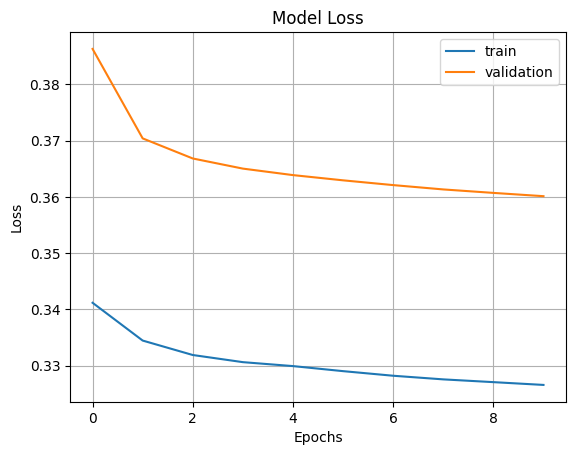

In [42]:
plt.plot(model_fit.history['loss'])
plt.plot(model_fit.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.grid()

plt.show()

In [43]:
def create_dataset_no_labels(features):
    feature_ds = tf.data.Dataset.from_tensor_slices((features['left'].values, features['right'].values))
    feature_ds = feature_ds.map(preprocessing)
    
    feature_ds = feature_ds.batch(batch_size, num_parallel_calls=tf.data.AUTOTUNE)
    feature_ds = feature_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
    
    return feature_ds

def create_singular_dataset(feature):
    dataset = tf.data.Dataset.from_tensor_slices(feature.values)
    dataset = dataset.map(convert_to_img)
    dataset = dataset.batch(batch_size, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
    
    return dataset

In [44]:
test_ds_left = create_singular_dataset(X_test['left'])
test_ds_right = create_singular_dataset(X_test['right'])
test_labels = Y_test_label['label']

test_ds_full = create_dataset_no_labels(X_test)

In [45]:
predictions = model.predict(val_ds)

28/28 [==============================] - 2s 77ms/step


In [46]:
predictions = predictions.flatten()
predictions = predictions.tolist()

In [47]:
test_labels

3520    1
3521    1
3522    1
3523    0
3524    0
       ..
3955    0
3956    0
3957    0
3958    1
3959    1
Name: label, Length: 440, dtype: int64

In [48]:
predictions_labels = pd.DataFrame({"labels":test_labels, 
                                   "predictions":predictions})
predictions_labels

,labels,predictions
3520,1,0.216473
3521,1,0.526247
3522,1,0.284326
3523,0,0.111817
3524,0,0.243793
...,...,...
3955,0,0.044373
3956,0,0.402633
3957,0,0.167161
3958,1,0.075659


In [49]:
predictions_labels_positive = predictions_labels["predictions"].loc[predictions_labels["labels"] == 1]
predictions_labels_negative = predictions_labels["predictions"].loc[predictions_labels["labels"] == 0]
positive_mean = predictions_labels_positive.mean()
negative_mean = predictions_labels_negative.mean()
positive_mean

0.26628048971972684

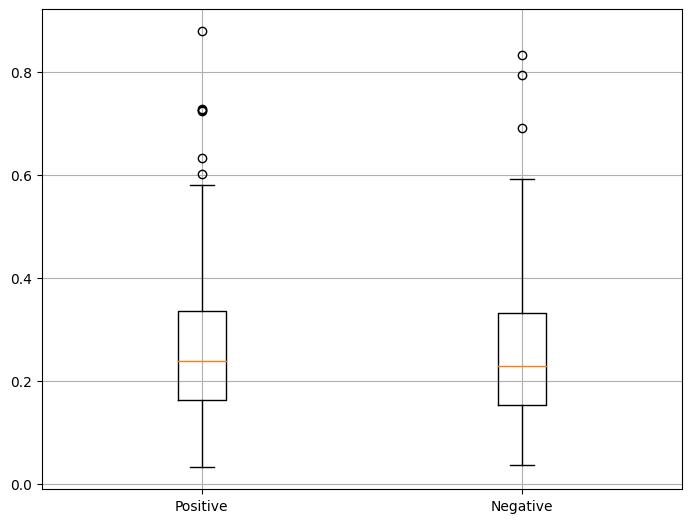

In [50]:
fig = plt.figure()
ax = fig.add_axes([0,0,1, 1])
ax.boxplot([predictions_labels_positive, predictions_labels_negative])
plt.xticks([1, 2], ['Positive', 'Negative'])
ax.grid()
plt.show()

In [51]:
def compute_accuracy(y_true, y_pred, cutoff):
    pred = y_pred < cutoff
    return np.mean(pred == y_true), pred

In [52]:
cutoff = (positive_mean + negative_mean)/2

test_accuracy, y_pred = compute_accuracy(test_labels, predictions, cutoff)
print(f'Accuracy: {test_accuracy*100:.2f}%')

Accuracy: 48.41%


In [46]:
#print(X_val.shape)
#print(Y_val_label.shape)

def visualize(pairs, labels, to_show=6, num_col=3, predictions=None, test=False):

    num_row = to_show // num_col if to_show // num_col != 0 else 1

    to_show = num_row * num_col

    fig, axes = plt.subplots(num_row, num_col, figsize=(5, 5))
    for i in range(to_show):

        if num_row == 1:
            ax = axes[i % num_col]
        else:
            ax = axes[i // num_col, i % num_col]

        ax.imshow(tf.concat([cv2.cvtColor(cv2.imread(pairs["left"].iloc[i]), cv2.COLOR_BGR2RGB), cv2.cvtColor(cv2.imread(pairs["right"].iloc[i]), cv2.COLOR_BGR2RGB)], axis=1), cmap="gray")
        ax.set_axis_off()
        if test:
            ax.set_title("True: {} | Pred: {:.5f}".format(labels["label"].iloc[i], predictions[i][0]))
        else:
            ax.set_title("Label: {}".format(labels[i]))
    if test:
        plt.tight_layout(rect=(0, 0, 1.9, 1.9), w_pad=0.0)
    else:
        plt.tight_layout(rect=(0, 0, 1.5, 1.5))
    plt.show()

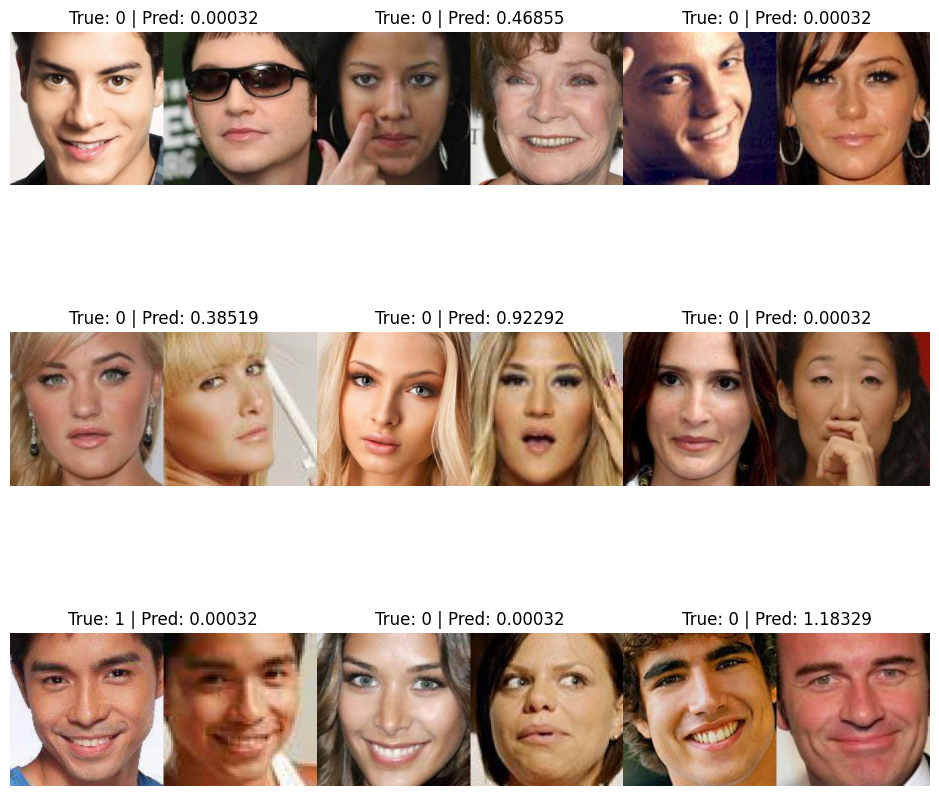

In [47]:
visualize(X_val, Y_val_label, to_show=9, num_col=3, predictions=predictions, test=True)

In [60]:
len(predictions)

440

In [61]:
len(test_labels)

440